# Insurance Claim Prediction

**Write the names of all group members (max. 5 members)**:
- Ramon, Kaspar
- Cyrill, Stotz

# Exercise 1 (Poisson GLM)

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn import preprocessing, model_selection, linear_model

RANDOM_STATE = 69   # for reproducibility

### Question 1.a

In [2]:
# Read csv file `freMTPL2freq.csv` (e.g. use pandas)
data_df = pd.read_csv('freMTPL2freq.csv', sep=';', decimal=',')
print("Column Names: ", data_df.columns)
print("Number of Rows: ", len(data_df))
assert len(data_df) == 678007

Column Names:  Index(['VehPower', 'VehAge', 'DrivAge', 'BonusMalus', 'VehBrand', 'VehGas',
       'Density', 'Region', 'Exposure', 'ClaimNb'],
      dtype='object')
Number of Rows:  678007


In [3]:
# Pre-process features

def preprocess_features(df):
    """Feature Engineering"""
    df_processed = df.copy()
    
    df_processed['VehPower'] = np.log(df_processed['VehPower'])
    df_processed['DrivAge'] = np.log(df_processed['DrivAge'])
    df_processed['BonusMalus'] = np.log(df_processed['BonusMalus'])
    df_processed['Density'] = np.log(df_processed['Density'])
    
    # Convert VehAge to categorical
    def categorize_veh_age(age):
        if age < 6:
            return '0-6'
        elif age < 13:
            return '6-13'
        else:
            return '13+'
        
    df_processed['VehAge'] = df_processed['VehAge'].apply(categorize_veh_age)

    return df_processed

# Calculate claim frequency, i.e., the target variable y
data_df['ClaimFreq'] = data_df['ClaimNb'] / data_df['Exposure']

# Preprocess features
data_processed_df = preprocess_features(data_df)

### Question 1.b

In [4]:
# Print some statistics about the data
print(f"Average Claim Frequency: {data_df['ClaimFreq'].mean()}")
print(f"Number of Claims: {data_df['ClaimNb'].sum()}")
number_of_policies_without_claims = len(data_df[data_df['ClaimNb'] == 0])
num_of_policies_without_claims_rel = 100*number_of_policies_without_claims / len(data_df)
print(f"Number of Policies without Claims: {number_of_policies_without_claims} ({num_of_policies_without_claims_rel:.2f}%)")
print(f"Number of NaNs: {data_processed_df.isna().sum().sum()}")

Average Claim Frequency: 0.11790710080746372
Number of Claims: 26383
Number of Policies without Claims: 653069 (96.32%)
Number of NaNs: 0


**COMMENT:** We can see that most policy holders have no claims at all (i.e., $96.32\%$ of the policy holders have zero claims). So when we would model the problem as binary classification, we would have a very imbalanced dataset. Therefore, Poisson regression is a good choice here. \
Furthermore, we don't have any NaNs in the dataset, so we don't have to deal with missing values – nice.

In [5]:
# Train-test split
X = data_processed_df.drop(['Exposure', 'ClaimNb', 'ClaimFreq'], axis=1)
y = data_df['ClaimFreq']
exposure = data_df['Exposure']

X_train, X_test, y_train, y_test, exposure_train, exposure_test = model_selection.train_test_split(
    X, y, exposure, test_size=0.1, random_state=RANDOM_STATE
)

# Separate features
categorical_features = ['VehAge', 'VehBrand', 'VehGas', 'Region']
numerical_features = ['VehPower', 'DrivAge', 'BonusMalus', 'Density']

# Scale numerical features
scaler = preprocessing.StandardScaler()
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

# One-hot encode categorical features using the training data (ensure numeric values and not booleans)
X_train = pd.get_dummies(X_train, columns=categorical_features, dtype=np.float32)
X_test = pd.get_dummies(X_test, columns=categorical_features, dtype=np.float32)

print("Features: ", X_train.columns)
print("Number of Features: ", len(X_train.columns))
assert len(X_train.columns) == len(X_test.columns)  # Ensure that the test and train set have same dimensions

Features:  Index(['VehPower', 'DrivAge', 'BonusMalus', 'Density', 'VehAge_0-6',
       'VehAge_13+', 'VehAge_6-13', 'VehBrand_B1', 'VehBrand_B10',
       'VehBrand_B11', 'VehBrand_B12', 'VehBrand_B13', 'VehBrand_B14',
       'VehBrand_B2', 'VehBrand_B3', 'VehBrand_B4', 'VehBrand_B5',
       'VehBrand_B6', 'VehGas_Diesel', 'VehGas_Regular', 'Region_R11',
       'Region_R21', 'Region_R22', 'Region_R23', 'Region_R24', 'Region_R25',
       'Region_R26', 'Region_R31', 'Region_R41', 'Region_R42', 'Region_R43',
       'Region_R52', 'Region_R53', 'Region_R54', 'Region_R72', 'Region_R73',
       'Region_R74', 'Region_R82', 'Region_R83', 'Region_R91', 'Region_R93',
       'Region_R94'],
      dtype='object')
Number of Features:  42


In [6]:
# Train Poisson GLM

# NOTE: We choose alpha=0 (without regularization)
poisson_reg = linear_model.PoissonRegressor(alpha=0)
poisson_reg.fit(X_train, y_train, sample_weight=exposure_train)

y_train_pred = poisson_reg.predict(X_train)
y_test_pred = poisson_reg.predict(X_test)

In [7]:
# Print MAE, MSE and loss on train and test data sets
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_poisson_deviance

def calculate_loss(y_true, y_pred, exposure, print_results=True):
    """Calculates MAE, MSE and the exposure-weighted Poisson deviance loss."""
    # Mean Absolute Error (MAE) and Mean Squared Error (MSE)
    mae = mean_absolute_error(y_true, y_pred)
    mae_weighted = mean_absolute_error(y_true, y_pred, sample_weight=exposure)
    mse = mean_squared_error(y_true, y_pred)
    mse_weighted = mean_squared_error(y_true, y_pred, sample_weight=exposure)
    
    # Calculate Poisson deviance loss (manually, and using sklearn built-in function)
    eps = 1e-8  # Avoid log(0)
    y_true_log = np.where(y_true > 0, y_true * np.log(y_true + eps), 0)
    y_pred_log = np.where(y_pred > 0, y_true * np.log(y_pred + eps), 0)
    poisson_deviance = 2 * (y_pred - y_true - y_pred_log + y_true_log)
    exp_weighted_poisson_loss = np.sum(exposure * poisson_deviance) / np.sum(exposure) if np.sum(exposure) > 0 else 0
    
    exp_weighted_poisson_loss_sklearn = mean_poisson_deviance(y_true, y_pred, sample_weight=exposure)
    
    if print_results:
        print("---------------------------------")
        print(f"MAE: {mae:.4f}")
        print(f"MAE (Weighted): {mae_weighted:.4f}")
        print(f"MSE: {mse:.4f}")
        print(f"MSE (Weighted): {mse_weighted:.4f}")
        print(f"Exposure-Weighted Poisson Deviance Loss: {exp_weighted_poisson_loss:.4f}")
        print(f"Exposure-Weighted Poisson Deviance Loss (sklearn): {exp_weighted_poisson_loss_sklearn:.4f}")
        print("---------------------------------")
    return mae, mae_weighted, mse, mse_weighted, exp_weighted_poisson_loss


# In-sample loss
print("In-sample Loss:")
poisson_glm_res_train = calculate_loss(y_train, y_train_pred, exposure_train)

# Out-of-sample loss
print("\nOut-of-sample Loss:")
poisson_glm_res_test = calculate_loss(y_test, y_test_pred, exposure_test)

In-sample Loss:
---------------------------------
MAE: 0.1876
MAE (Weighted): 0.1377
MSE: 3.7329
MSE (Weighted): 0.2347
Exposure-Weighted Poisson Deviance Loss: 0.4563
Exposure-Weighted Poisson Deviance Loss (sklearn): 0.4563
---------------------------------

Out-of-sample Loss:
---------------------------------
MAE: 0.2010
MAE (Weighted): 0.1387
MSE: 6.5031
MSE (Weighted): 0.2597
Exposure-Weighted Poisson Deviance Loss: 0.4627
Exposure-Weighted Poisson Deviance Loss (sklearn): 0.4627
---------------------------------


**COMMENT:** From the small increase in the loss from the training to the test set, we can conclude that the model generalizes well.

# Exercise 2 (Poisson FNN)

### Question 2.a

In [8]:
# Neural network implementation
import torch
from torch import nn
from torch import optim

class PoissonNN(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(PoissonNN, self).__init__()
        
        self.network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
        )
    
    def forward(self, x):
        x = self.network(x).squeeze()   # Squeeze to remove extra dimension
        # Exponential activation function
        return torch.exp(x)

### Question 2.b

In [9]:
from torch.utils.data import TensorDataset, DataLoader

# Convert data to tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
exposure_train_tensor = torch.tensor(exposure_train.values, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)
exposure_test_tensor = torch.tensor(exposure_test.values, dtype=torch.float32)

# Create data loaders

BATCH_SIZE = 10000

train_dataset = TensorDataset(X_train_tensor, y_train_tensor, exposure_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor, exposure_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [10]:
def poisson_loss(y_pred, y_true, exposure):
    """Calculate exposure-weighted Poisson deviance loss."""
    zero_tensor = torch.zeros_like(y_true)
    # Avoid log(0) by adding a small epsilon
    epsilon = 1e-8
    y_true_log = torch.where(y_true > 0, y_true * torch.log(y_true + epsilon), zero_tensor)
    y_pred_log = y_true * torch.log(y_pred + epsilon)
    poisson_deviance = 2 * (y_pred - y_true - y_pred_log + y_true_log)
    # Exposure-weighted Poisson deviance loss
    exp_weighted_poisson_loss = torch.sum(exposure * poisson_deviance) / torch.sum(exposure)
    return exp_weighted_poisson_loss

In [11]:
# Train Poisson feedforward neural network model

input_dim = X_train.shape[1]
print("Input Dimension: ", input_dim)

HIDDEN_DIM = 20

model = PoissonNN(input_dim=input_dim, hidden_dim=HIDDEN_DIM)
print(model)

LEARNING_RATE = 0.01
EPOCHS = 100

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

train_losses = []
val_losses = []

for epoch in range(EPOCHS):
    # Training
    model.train()
    train_loss = 0
    total_samples = 0
    for X_batch, y_batch, exp_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = poisson_loss(y_pred, y_batch, exp_batch)
        loss.backward()
        optimizer.step()
        batch_size = X_batch.size(0)
        train_loss += loss.item() * batch_size
        total_samples += batch_size

    train_loss /= total_samples

    # Validation
    model.eval()
    val_loss = 0
    total_val_samples = 0
    with torch.no_grad():
        for X_batch, y_batch, exp_batch in test_loader:
            y_pred = model(X_batch)
            loss = poisson_loss(y_pred, y_batch, exp_batch)
            batch_size = X_batch.size(0)
            val_loss += loss.item() * batch_size
            total_val_samples += batch_size

    val_loss /= total_val_samples

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f'Epoch {epoch}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

Input Dimension:  42
PoissonNN(
  (network): Sequential(
    (0): Linear(in_features=42, out_features=20, bias=True)
    (1): ReLU()
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): ReLU()
    (4): Linear(in_features=20, out_features=1, bias=True)
  )
)
Epoch 0: Train Loss: 0.6517, Val Loss: 0.4642
Epoch 1: Train Loss: 0.4575, Val Loss: 0.4629
Epoch 2: Train Loss: 0.4568, Val Loss: 0.4620
Epoch 3: Train Loss: 0.4564, Val Loss: 0.4622
Epoch 4: Train Loss: 0.4558, Val Loss: 0.4618
Epoch 5: Train Loss: 0.4555, Val Loss: 0.4615
Epoch 6: Train Loss: 0.4553, Val Loss: 0.4615
Epoch 7: Train Loss: 0.4551, Val Loss: 0.4602
Epoch 8: Train Loss: 0.4540, Val Loss: 0.4595
Epoch 9: Train Loss: 0.4532, Val Loss: 0.4586
Epoch 10: Train Loss: 0.4525, Val Loss: 0.4590
Epoch 11: Train Loss: 0.4522, Val Loss: 0.4578
Epoch 12: Train Loss: 0.4522, Val Loss: 0.4578
Epoch 13: Train Loss: 0.4515, Val Loss: 0.4573
Epoch 14: Train Loss: 0.4515, Val Loss: 0.4577
Epoch 15: Train Loss: 0.4514, V

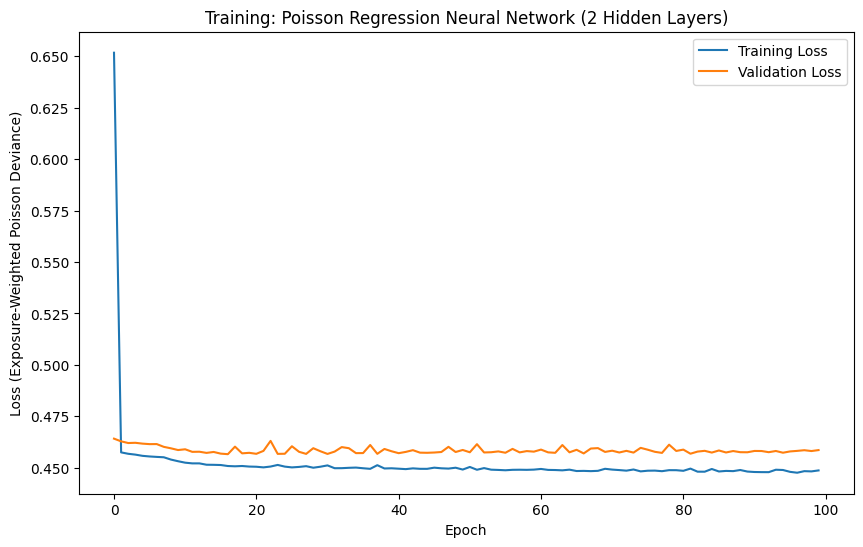

In [12]:
# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (Exposure-Weighted Poisson Deviance)')
plt.title(f'Training: Poisson Regression Neural Network (2 Hidden Layers)')
plt.legend()
plt.savefig('plots/training_history_FNN_1.png')

In [13]:
# Print MAE, MSE and loss on train and test data sets
def evaluate_model(nn_model, X, y, exposure):
    nn_model.eval()
    with torch.no_grad():
        X_tensor = torch.FloatTensor(X.values)
        y_pred = nn_model(X_tensor).numpy()
        return calculate_loss(y, y_pred, exposure)

print("\nTraining Set:")
fnn_1_res_train = evaluate_model(model, X_train, y_train, exposure_train)

print("\nTest Set:")
fnn_1_res_test = evaluate_model(model, X_test, y_test, exposure_test)


Training Set:
---------------------------------
MAE: 0.1982
MAE (Weighted): 0.1466
MSE: 3.7293
MSE (Weighted): 0.2336
Exposure-Weighted Poisson Deviance Loss: 0.4485
Exposure-Weighted Poisson Deviance Loss (sklearn): 0.4485
---------------------------------

Test Set:
---------------------------------
MAE: 0.2120
MAE (Weighted): 0.1482
MSE: 6.4982
MSE (Weighted): 0.2591
Exposure-Weighted Poisson Deviance Loss: 0.4587
Exposure-Weighted Poisson Deviance Loss (sklearn): 0.4587
---------------------------------


**COMMENT:** We can see, that we outperform the Poisson GLM model by a small margin only. We can also see, that after the first few epochs, the loss stays almost constant – the model converged. This suggests that there are too few parameters in the model to capture the complexity of the data (underfitting). So we try a different model with a hidden layer more and more neurons.

### Train new Poisson feedforward Neural Network with more parameters

Here, we train a new Poisson feedforward neural network with more parameters. We use 3 hidden layers with 128, 64 and 64 neurons. In order to avoid overfitting, we use regularization in the optimizer.

In [14]:
class PoissonNN_new(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, hidden_dim3):
        super(PoissonNN_new, self).__init__()
        
        self.network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim1),
            nn.BatchNorm1d(hidden_dim1),
            nn.ReLU(),
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.BatchNorm1d(hidden_dim2),
            nn.ReLU(),
            nn.Linear(hidden_dim2, hidden_dim3),
            nn.BatchNorm1d(hidden_dim3),
            nn.ReLU(),
            nn.Linear(hidden_dim3, 1)
        )
    
    def forward(self, x):
        x = self.network(x).squeeze()   # Squeeze to remove extra dimension
        # Exponential activation function
        return torch.exp(x)

In [15]:
# Train Poisson Neural Network with regularization
model_new = PoissonNN_new(input_dim=input_dim, hidden_dim1=256, hidden_dim2=128, hidden_dim3=64)
print(model_new)

# NOTE: We use L2 regularization (weight decay) in the optimizer
# TODO: Implement Cross-Validation for L2 regularization
EPOCHS = 100
REGULARIZATION = 0.01
LEARNING_RATE = 0.001
optimizer = optim.Adam(model_new.parameters(), lr=LEARNING_RATE, weight_decay=REGULARIZATION)

train_losses = []
val_losses = []

for epoch in range(EPOCHS):
    # Training
    model_new.train()
    train_loss = 0
    total_exposure_train = 0.0
    for X_batch, y_batch, exp_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model_new(X_batch)
        loss = poisson_loss(y_pred, y_batch, exp_batch)
        loss.backward()
        optimizer.step()
        batch_size = X_batch.size(0)
        # Accumulate total loss and total exposure
        train_loss += loss.item() * exp_batch.sum().item()
        total_exposure_train += exp_batch.sum().item()

    # Compute the average exposure-weighted loss for the epoch
    train_loss /= total_exposure_train

    # Validation
    model_new.eval()
    val_loss = 0
    total_exposure_val = 0.0
    with torch.no_grad():
        for X_batch, y_batch, exp_batch in test_loader:
            y_pred = model_new(X_batch)
            loss = poisson_loss(y_pred, y_batch, exp_batch)
            # Accumulate total loss and total exposure
            val_loss += loss.item() * exp_batch.sum().item()
            total_exposure_val += exp_batch.sum().item()

    # Compute the average exposure-weighted loss for the epoch
    val_loss /= total_exposure_val

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f'Epoch {epoch}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

PoissonNN_new(
  (network): Sequential(
    (0): Linear(in_features=42, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Linear(in_features=64, out_features=1, bias=True)
  )
)
Epoch 0: Train Loss: 0.8409, Val Loss: 0.5688
Epoch 1: Train Loss: 0.4918, Val Loss: 0.5009
Epoch 2: Train Loss: 0.4645, Val Loss: 0.4752
Epoch 3: Train Loss: 0.4585, Val Loss: 0.4664
Epoch 4: Train Loss: 0.4560, Val Loss: 0.4617
Epoch 5: Train Loss: 0.4559, Val Loss: 0.4623
Epoch 6: Train Loss: 0.4551, Val Loss: 0.4687
Epoch 7: Train Loss: 0.4555, Val Loss: 0.4763
Epoch 8: Train Loss: 0.455


Training Set:
---------------------------------
MAE: 0.1911
MAE (Weighted): 0.1401
MSE: 3.7310
MSE (Weighted): 0.2337
Exposure-Weighted Poisson Deviance Loss: 0.4486
Exposure-Weighted Poisson Deviance Loss (sklearn): 0.4486
---------------------------------

Test Set:
---------------------------------
MAE: 0.2046
MAE (Weighted): 0.1413
MSE: 6.5003
MSE (Weighted): 0.2590
Exposure-Weighted Poisson Deviance Loss: 0.4565
Exposure-Weighted Poisson Deviance Loss (sklearn): 0.4565
---------------------------------


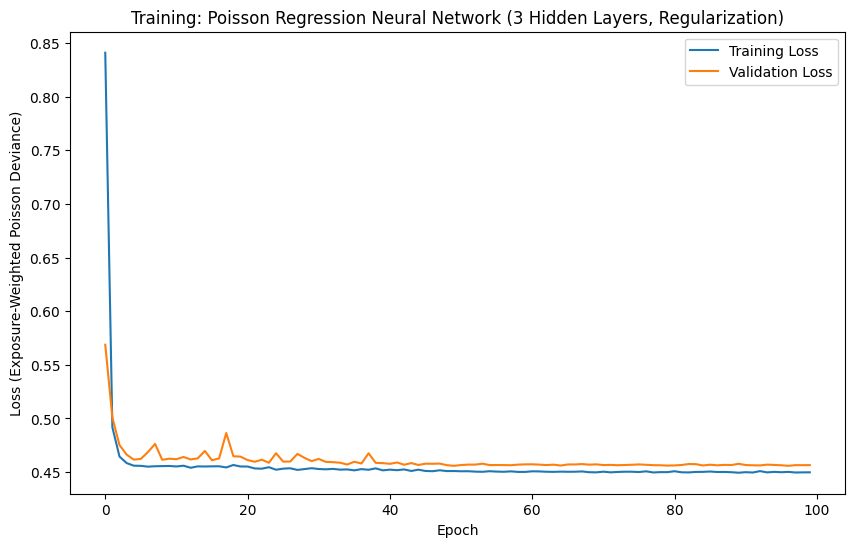

In [16]:
# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (Exposure-Weighted Poisson Deviance)')
plt.title(f'Training: Poisson Regression Neural Network (3 Hidden Layers, Regularization)')
plt.legend()
plt.savefig('plots/training_history_FNN_2.png')

# Evaluate model
print("\nTraining Set:")
fnn_2_res_train = evaluate_model(model_new, X_train, y_train, exposure_train)

print("\nTest Set:")
fnn_2_res_test = evaluate_model(model_new, X_test, y_test, exposure_test)

# Exercise 3 (Tree-based methods)

In [17]:
from sklearn import tree, ensemble, model_selection

# Ignore warning (we got lots of warning during GridSearchCV for too extreme hyperparameters)
import warnings
warnings.filterwarnings("ignore")

### Question 3.a

In [18]:
# Implement a regression tree
reg_tree = tree.DecisionTreeRegressor(criterion='poisson')

# Cross-validation on min_impurity_decrease hyperparameter
reg_tree_cv = model_selection.GridSearchCV(
    reg_tree, 
    param_grid={'min_impurity_decrease': np.linspace(0, 1.0, 100)}, 
    cv=5, 
    scoring='neg_mean_poisson_deviance',
    verbose=1,
    n_jobs=-1
)
reg_tree_cv.fit(X_train, y_train, sample_weight=exposure_train)

print("Best Hyperparameters: ", reg_tree_cv.best_params_)
print("Best Score: ", reg_tree_cv.best_score_)
best_reg_tree = reg_tree_cv.best_estimator_

# Print MAE, MSE and loss on train and test data sets
y_train_pred = best_reg_tree.predict(X_train)
y_test_pred = best_reg_tree.predict(X_test)

print("\nTraining Set:")
reg_tree_res_train = calculate_loss(y_train, y_train_pred, exposure_train)

print("\nTest Set:")
reg_tree_res_test = calculate_loss(y_test, y_test_pred, exposure_test)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Hyperparameters:  {'min_impurity_decrease': 0.010101010101010102}
Best Score:  -1.0070097116321932

Training Set:
---------------------------------
MAE: 0.1847
MAE (Weighted): 0.1399
MSE: 3.7364
MSE (Weighted): 0.2366
Exposure-Weighted Poisson Deviance Loss: 0.4769
Exposure-Weighted Poisson Deviance Loss (sklearn): 0.4769
---------------------------------

Test Set:
---------------------------------
MAE: 0.1981
MAE (Weighted): 0.1409
MSE: 6.5078
MSE (Weighted): 0.2617
Exposure-Weighted Poisson Deviance Loss: 0.4830
Exposure-Weighted Poisson Deviance Loss (sklearn): 0.4830
---------------------------------


### Question 3.b

In [19]:
# Implement a random forest model
rf_reg = ensemble.RandomForestRegressor(criterion='poisson')

# Cross-validation
rf_cv = model_selection.GridSearchCV(
    rf_reg,
    param_grid = {
        'random_state': [RANDOM_STATE],
        'n_jobs': [-1], # Parallelize training
        'min_impurity_decrease': np.linspace(0, 0.1, 10),
        # number of features to consider when looking for best split, if None then max_features=n_features
        'max_features': ['sqrt', 'log2', None, 1, 10, 100]
    },
    cv=5,
    scoring='neg_mean_poisson_deviance',
    verbose=1,
    n_jobs=-1
)
rf_cv.fit(X_train, y_train, sample_weight=exposure_train)

print("\nRandom Forest Results:")
print("Best Hyperparameters: ", rf_cv.best_params_)
print("Best Score: ", rf_cv.best_score_)
best_rf = rf_cv.best_estimator_

# Print MAE, MSE and loss on train and test data sets
y_train_pred_rf = best_rf.predict(X_train)
y_test_pred_rf = best_rf.predict(X_test)

print("\nTraining Set:")
rf_reg_res_train = calculate_loss(y_train, y_train_pred_rf, exposure_train)

print("\nTest Set:")
rf_reg_res_test = calculate_loss(y_test, y_test_pred_rf, exposure_test)

Fitting 5 folds for each of 60 candidates, totalling 300 fits

Random Forest Results:
Best Hyperparameters:  {'max_features': 1, 'min_impurity_decrease': 0.0, 'n_jobs': -1, 'random_state': 69}
Best Score:  -0.9798756782216165

Training Set:
---------------------------------
MAE: 0.1817
MAE (Weighted): 0.1323
MSE: 3.5533
MSE (Weighted): 0.2185
Exposure-Weighted Poisson Deviance Loss: 0.3629
Exposure-Weighted Poisson Deviance Loss (sklearn): 0.3629
---------------------------------

Test Set:
---------------------------------
MAE: 0.2039
MAE (Weighted): 0.1420
MSE: 6.5061
MSE (Weighted): 0.2641
Exposure-Weighted Poisson Deviance Loss: 0.4655
Exposure-Weighted Poisson Deviance Loss (sklearn): 0.4655
---------------------------------


### Question 3.c

In [29]:
# Implement gradient boosted trees
# NOTE: We use the Histogram-based Gradient Boosting Regressor as it is much faster than the "normal" Gradient Boosting Regressor
gb_reg = ensemble.HistGradientBoostingRegressor(loss='poisson')

# Cross-validation
gb_cv = model_selection.GridSearchCV(
    gb_reg,
    param_grid = {
        'random_state': [RANDOM_STATE],
        'learning_rate': [0.01, 0.1, 0.3],  # shrinkage parameter
        'max_iter': [100, 200, 300]     # number of boosting steps
    },
    cv=5,
    scoring='neg_mean_poisson_deviance',
    verbose=1,
    n_jobs=-1
)
gb_cv.fit(X_train, y_train, sample_weight=exposure_train)

print("\nGradient Boosting Results:")
print("Best Hyperparameters: ", gb_cv.best_params_)
print("Best Score: ", gb_cv.best_score_)
best_gb = gb_cv.best_estimator_

# Print MAE, MSE and loss on train and test data sets
y_train_pred_gb = best_gb.predict(X_train)
y_test_pred_gb = best_gb.predict(X_test)

print("\nTraining Set:")
gb_reg_res_train = calculate_loss(y_train, y_train_pred_gb, exposure_train)

print("\nTest Set:")
gb_reg_res_test = calculate_loss(y_test, y_test_pred_gb, exposure_test)

Fitting 5 folds for each of 9 candidates, totalling 45 fits

Gradient Boosting Results:
Best Hyperparameters:  {'learning_rate': 0.01, 'max_iter': 300, 'random_state': 69}
Best Score:  -0.9712236157788438

Training Set:
---------------------------------
MAE: 0.1863
MAE (Weighted): 0.1358
MSE: 3.7305
MSE (Weighted): 0.2329
Exposure-Weighted Poisson Deviance Loss: 0.4435
Exposure-Weighted Poisson Deviance Loss (sklearn): 0.4435
---------------------------------

Test Set:
---------------------------------
MAE: 0.1999
MAE (Weighted): 0.1371
MSE: 6.5000
MSE (Weighted): 0.2583
Exposure-Weighted Poisson Deviance Loss: 0.4521
Exposure-Weighted Poisson Deviance Loss (sklearn): 0.4521
---------------------------------


## 4. Comparison of all the models & Conclusion

In this section, we compare all the considered models, that is:
- Poisson GLM
- Poisson FNN (42-20-20-1)
- Poisson FNN with more parameters (42-256-128-64-1) & regularization
- Regression Tree (CART)
- Random Forest
- Gradient Boosting

|          Model           |   Train MAE (weighted) |   Train MSE (weighted) |   Possion Train Loss |   Test MAE (weighted) |   Test MSE (weighted) |   Possion Test Loss |
|:------------------------:|-----------------------:|-----------------------:|---------------------:|----------------------:|----------------------:|--------------------:|
|       Poisson GLM        |                 0.1377 |                 0.2347 |               0.4563 |                0.1387 |                0.2597 |              0.4627 |
|   Poisson NN (Simple)    |                 0.1466 |                 0.2336 |               0.4485 |                0.1482 |                0.2591 |              0.4587 |
| Poisson NN (Regularized) |                 0.1401 |                 0.2337 |               0.4486 |                0.1413 |                0.259  |              0.4565 |
|     Regression Tree      |                 0.1399 |                 0.2366 |               0.4769 |                0.1409 |               

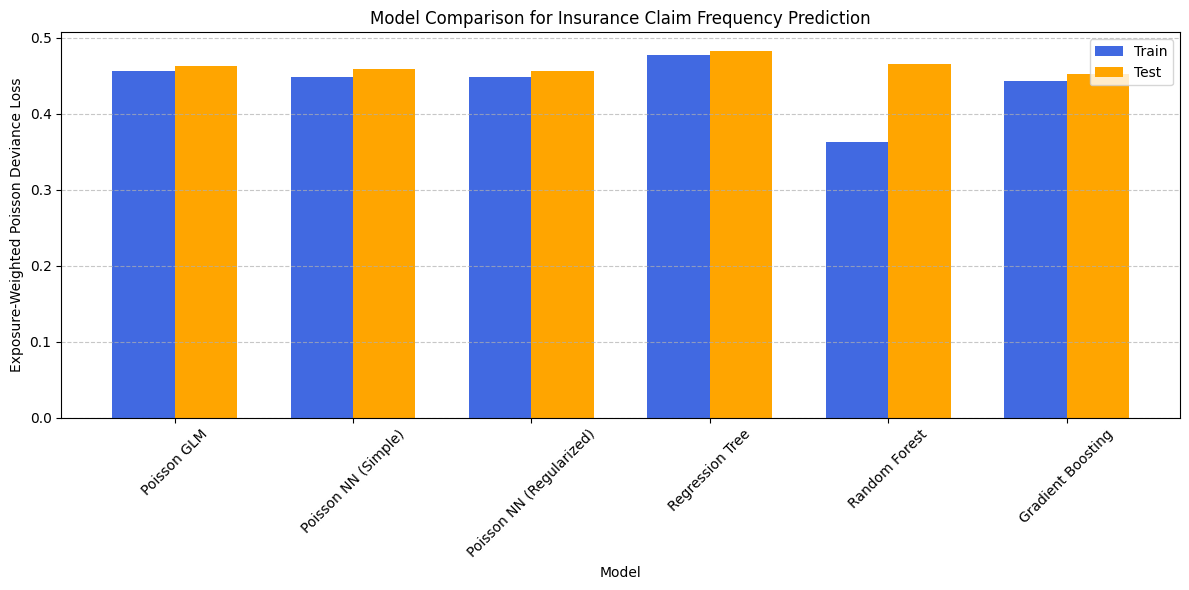

In [48]:
results = {
    'Poisson GLM': {
        'Train': poisson_glm_res_train,
        'Test': poisson_glm_res_test
    },
    'Poisson NN (Simple)': {
        'Train': fnn_1_res_train,
        'Test': fnn_1_res_test
    },
    'Poisson NN (Regularized)': {
        'Train': fnn_2_res_train,
        'Test': fnn_2_res_test
    },
    'Regression Tree': {
        'Train': reg_tree_res_train,
        'Test': reg_tree_res_test
    },
    'Random Forest': {
        'Train': rf_reg_res_train,
        'Test': rf_reg_res_test
    },
    'Gradient Boosting': {
        'Train': gb_reg_res_train,
        'Test': gb_reg_res_test
    }
}

# Plot results in a table
from tabulate import tabulate

table_data = []
headers = ['Model', 'Train MAE (weighted)', 'Train MSE (weighted)', 'Possion Train Loss', 'Test MAE (weighted)', 'Test MSE (weighted)', 'Possion Test Loss']

for model_name, model_results in results.items():
    train_mae, train_mae_weighted, train_mse, train_mse_weighted, train_poisson_loss = model_results['Train']
    test_mae, test_mae_weighted, test_mse, test_mse_weighted, test_poisson_loss = model_results['Test']
    
    table_data.append([
        model_name,
        f'{train_mae_weighted:.4f}',
        f'{train_mse_weighted:.4f}',
        f'{train_poisson_loss:.4f}',
        f'{test_mae_weighted:.4f}',
        f'{test_mse_weighted:.4f}',
        f'{test_poisson_loss:.4f}'
    ])

# Print table
print(tabulate(table_data, headers=headers, tablefmt='pipe', stralign='center'))

# Plot results as a bar chart
plt.figure(figsize=(12, 6))

train_poisson_loss = [results[model]['Train'][4] for model in results]
test_poisson_loss = [results[model]['Test'][4] for model in results]
bar_width = 0.35
index = np.arange(len(results))

plt.bar(index, train_poisson_loss, bar_width, label='Train', color='royalblue')
plt.bar(index + bar_width, test_poisson_loss, bar_width, label='Test', color='orange')

plt.xlabel('Model')
plt.ylabel('Exposure-Weighted Poisson Deviance Loss')
plt.title('Model Comparison for Insurance Claim Frequency Prediction')
plt.xticks(index + bar_width / 2, results.keys(), rotation=45)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7, axis='y')
plt.tight_layout()
plt.savefig('plots/model_comparison.png', dpi=1000)

**COMMENT:** Conclusion after implementing and benchmarking different models for insurance claim frequency prediction:
* Both Neural Network variants slightly outperformed the traditional Poisson GLM (test loss: 0.4587/0.4565 vs 0.4627)
* The (Histogram) Gradient Boosting Regressor showed the best performance with the lowest test loss (0.4521) and significantly faster training time compared to the Neural Networks.
* Random Forest showed signs of overfitting with the best training loss (0.3629) but higher test loss (0.4655)

In conclusion, while Neural Networks improve upon the GLM baseline, the Gradient Boosting Regressor outperforms all of them (in terms of exposure-weighted Poisson deviance loss and computation time) and is therefore the best choice for this task.